In [1]:
import string
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output
from random import sample
import json
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import tqdm

In [2]:
POETRY_FILE_PATH = "./sonnets.txt"

# Data loading

In [3]:
with open(POETRY_FILE_PATH, 'r', encoding="utf-8") as iofile:
    text = iofile.readlines()

TEXT_START = 45
TEXT_END = -368

text = text[TEXT_START:TEXT_END]
text[:10]

['  From fairest creatures we desire increase,\n',
 "  That thereby beauty's rose might never die,\n",
 '  But as the riper should by time decease,\n',
 '  His tender heir might bear his memory:\n',
 '  But thou, contracted to thine own bright eyes,\n',
 "  Feed'st thy light's flame with self-substantial fuel,\n",
 '  Making a famine where abundance lies,\n',
 '  Thy self thy foe, to thy sweet self too cruel:\n',
 "  Thou that art now the world's fresh ornament,\n",
 '  And only herald to the gaudy spring,\n']

In [4]:
text = [sentence.lower() for sentence in text] # Your great code here
text = "".join(text)

In [5]:
tokens = set(text)
num_tokens = len(tokens)
num_tokens

38

In [6]:
idx_to_token = {idx: token for idx, token in enumerate(tokens)}

token_to_idx = {token: idx for idx, token in enumerate(tokens)}

In [7]:
txt = text.split("\n\n")[::2]
txt[:3]

["  from fairest creatures we desire increase,\n  that thereby beauty's rose might never die,\n  but as the riper should by time decease,\n  his tender heir might bear his memory:\n  but thou, contracted to thine own bright eyes,\n  feed'st thy light's flame with self-substantial fuel,\n  making a famine where abundance lies,\n  thy self thy foe, to thy sweet self too cruel:\n  thou that art now the world's fresh ornament,\n  and only herald to the gaudy spring,\n  within thine own bud buriest thy content,\n  and tender churl mak'st waste in niggarding:\n    pity the world, or else this glutton be,\n    to eat the world's due, by the grave and thee.",
 "  when forty winters shall besiege thy brow,\n  and dig deep trenches in thy beauty's field,\n  thy youth's proud livery so gazed on now,\n  will be a tatter'd weed of small worth held:\n  then being asked, where all thy beauty lies,\n  where all the treasure of thy lusty days;\n  to say, within thine own deep sunken eyes,\n  were an al

In [8]:
class Poems(Dataset):
    def __init__(self, poems):
        self.poems = poems
    
    def __len__(self):
        return len(self.poems)
    
    def __getitem__(self, idx):
        return self.poems[idx]
    

def to_matrix(sentences, max_len=None, pad=token_to_idx[' '], dtype='int32', batch_first = True):
    """Casts a list of sentences into rnn-digestable matrix"""
    
    max_len = max_len or max(map(len, sentences))
    sentences_ix = np.zeros([len(sentences), max_len], dtype) + pad

    for i in range(len(sentences)):
        line_ix = [token_to_idx[c] for c in sentences[i]]
        sentences_ix[i, :len(line_ix)] = line_ix[:max_len]
        
    if not batch_first:
        sentences_ix = np.transpose(sentences_ix)

    return sentences_ix

poems = Poems(txt)

In [9]:
poems[0]

"  from fairest creatures we desire increase,\n  that thereby beauty's rose might never die,\n  but as the riper should by time decease,\n  his tender heir might bear his memory:\n  but thou, contracted to thine own bright eyes,\n  feed'st thy light's flame with self-substantial fuel,\n  making a famine where abundance lies,\n  thy self thy foe, to thy sweet self too cruel:\n  thou that art now the world's fresh ornament,\n  and only herald to the gaudy spring,\n  within thine own bud buriest thy content,\n  and tender churl mak'st waste in niggarding:\n    pity the world, or else this glutton be,\n    to eat the world's due, by the grave and thee."

# Learning

In [10]:
import torch, torch.nn as nn
import torch.nn.functional as F

## vanilla RNN

In [11]:
from models import CharRNNCell, train_char_rnn

### vanilla RNN without dropout

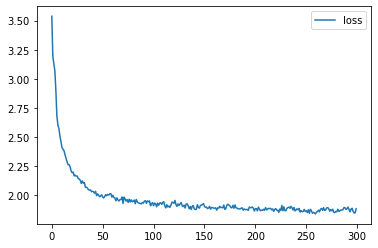

training...: 100%|███████████████████████████████████████████████████████████████████| 300/300 [04:51<00:00,  1.03it/s]


CharRNNCell(
  (emb): Embedding(38, 32)
  (rnn): Linear(in_features=288, out_features=256, bias=True)
  (hid_to_logits): Linear(in_features=256, out_features=38, bias=True)
)

In [12]:
char_rnn = CharRNNCell(num_tokens=num_tokens)
criterion = nn.NLLLoss()
opt = torch.optim.Adam(char_rnn.parameters())
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    opt, 
    patience=5,
    factor=0.5
)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 32
EPOCHS = 300
history = []

train_char_rnn(
    char_rnn, 
    poems, 
    criterion, 
    opt, 
    scheduler, 
    history, 
    token_to_idx, 
    num_tokens, 
    device, 
    epochs=EPOCHS, 
    batch_size=BATCH_SIZE
)
torch.save(char_rnn.state_dict(), 'runs/vanillaRNN.pt')
char_rnn.to('cpu')

## LSTM

In [14]:
from models import LSTM, train_lstm

### LSTM without weights dropout

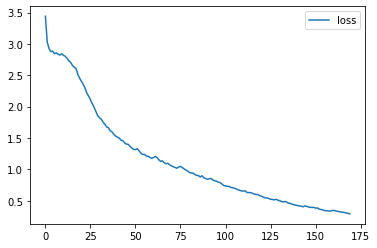

training...: 100%|███████████████████████████████████████████████████████████████████| 170/170 [01:20<00:00,  2.10it/s]


LSTM(
  (emb): Embedding(38, 32)
  (lstm): LSTM(32, 256, num_layers=2, batch_first=True)
  (hid_to_logits): Linear(in_features=256, out_features=38, bias=True)
)

In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
lstm = LSTM(num_tokens=num_tokens, n_layers=2)
criterion = nn.NLLLoss()
opt = torch.optim.Adam(lstm.parameters(), lr=1e-2)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    opt, 
    patience=5,
    factor=0.5
)
BATCH_SIZE = 32
EPOCHS = 170
history = []

train_lstm(
    lstm, 
    poems, 
    criterion, 
    opt, 
    scheduler, 
    history, 
    token_to_idx, 
    num_tokens, 
    device, 
    epochs=EPOCHS, 
    batch_size=BATCH_SIZE
)
torch.save(lstm.state_dict(), 'runs/LSTM.pt')
lstm.to('cpu')

### LSTM with weights dropout

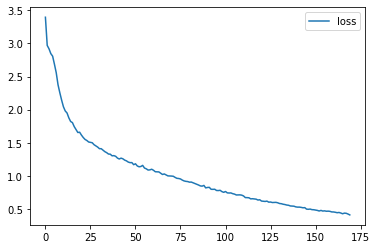

training...: 100%|███████████████████████████████████████████████████████████████████| 170/170 [01:20<00:00,  2.10it/s]


LSTM(
  (emb): Embedding(38, 32)
  (lstm): WeightDrop(
    (module): LSTM(32, 256, num_layers=2, batch_first=True)
  )
  (hid_to_logits): Linear(in_features=256, out_features=38, bias=True)
)

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
lstm_with_weight_dropout = LSTM(num_tokens=num_tokens, n_layers=2, weight_dropout=0.3)
criterion = nn.NLLLoss()
opt = torch.optim.Adam(lstm_with_weight_dropout.parameters(), lr=1e-2)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    opt, 
    patience=5,
    factor=0.5
)
BATCH_SIZE = 32
EPOCHS = 170
history = []

train_lstm(
    lstm_with_weight_dropout, 
    poems, 
    criterion, 
    opt, 
    scheduler, 
    history, 
    token_to_idx, 
    num_tokens, 
    device, 
    epochs=EPOCHS, 
    batch_size=BATCH_SIZE
)
torch.save(lstm_with_weight_dropout.state_dict(), 'runs/LSTM_with_weight_dropout.pt')
lstm_with_weight_dropout.to('cpu')

# Generating poems

## Generating vanilla RNN

In [34]:
def generate_sample_rnn(model, seed_phrase=' i', max_length=300, temperature=1.0):
    '''
    ### Disclaimer: this is an example function for text generation.
    ### You can either adapt it in your code or create your own function
    
    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs, 
        smaller temperature converges to the single most likely output.
        
    Be careful with the model output. This model waits logits (not probabilities/log-probabilities)
    of the next symbol.
    '''
    
    x_sequence = [token_to_idx[token] for token in seed_phrase]
    x_sequence = torch.tensor([x_sequence], dtype=torch.int64)
    hid_state = model.initial_state(batch_size=1)
    
    for i in range(len(seed_phrase) - 1):
        hid_state, out = model(x_sequence[:, i], hid_state)
    
    #start generating
    for _ in range(max_length - len(seed_phrase)):
        hid_state, out = model(x_sequence[:, -1], hid_state)
        p_next = F.softmax(out / temperature, dim=-1).data.numpy()[0]
        
        # sample next token and push it back into x_sequence
        next_ix = np.random.choice(len(tokens), p=p_next)
        next_ix = torch.tensor([[next_ix]], dtype=torch.int64)
        x_sequence = torch.cat([x_sequence, next_ix], dim=1)
    
    return ''.join([idx_to_token[ix] for ix in x_sequence.data.numpy()[0]])

In [51]:
char_rnn.eval()
print('temperature = 0.1:\n', generate_sample_rnn(char_rnn, seed_phrase=' i', max_length=300, temperature=0.1))
print()
print('temperature = 0.5:\n', generate_sample_rnn(char_rnn, seed_phrase=' i', max_length=300, temperature=0.5))
print()
print('temperature = 1.0:\n', generate_sample_rnn(char_rnn, seed_phrase=' i', max_length=300, temperature=1.0))

temperature = 0.1:
  in the  and the  for the  for the  far  he  t  t                                                                                                                                                                                                                                                           

temperature = 0.5:
  int or thaube thy shoug the  ay er me and th the for ther hith more,
   or sere thas  ald su f thin  in de the ther comen'sthe ther the  on the  ald sh th t ches be  we th  he   ar  n     a                                                                                                              

temperature = 1.0:
  ingi co if sat,
  a thou ast ine gralt bo wirchyerung tanein ald makearn cincensteri fiand?
  in  falll wer  of thoug'ns, dtsee!
  thingredishevensanghoslonkewsacl wiescouspatime's lostary,
  war, wol in poor my lo ke hrew ing ther'd son thount, weecemuthed shit thopree, when will but mid beauthind


## Generating LSTM

In [38]:
def generate_sample_lstm(model, seed_phrase=' i', max_length=300, temperature=1.0):
    '''
    ### Disclaimer: this is an example function for text generation.
    ### You can either adapt it in your code or create your own function
    
    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs, 
        smaller temperature converges to the single most likely output.
        
    Be careful with the model output. This model waits logits (not probabilities/log-probabilities)
    of the next symbol.
    '''
    
    x_sequence = [token_to_idx[token] for token in seed_phrase]
    x_sequence = torch.tensor([x_sequence], dtype=torch.int64)
    hidden = model.initial_state(1, "cpu")
    
    #feed the seed phrase, if any
    for i in range(len(seed_phrase) - 1):
        out, hidden = model(x_sequence[:, i][None], hidden)
    
    #start generating
    for _ in range(max_length - len(seed_phrase)):
        out, hidden = model(x_sequence[:, -1][None], hidden)
        # Be really careful here with the model output
        p_next = F.softmax(out[0] / temperature, dim=-1).data.numpy()[0]
        
        # sample next token and push it back into x_sequence
        next_ix = np.random.choice(len(tokens), p=p_next)
        next_ix = torch.tensor([[next_ix]], dtype=torch.int64)
        x_sequence = torch.cat([x_sequence, next_ix], dim=1)
    
    return ''.join([idx_to_token[ix] for ix in x_sequence.data.numpy()[0]])

In [53]:
lstm.eval()
print('temperature = 0.1:\n', generate_sample_lstm(lstm, seed_phrase=' i', max_length=300, temperature=0.1))
print()
print('temperature = 0.5:\n', generate_sample_lstm(lstm, seed_phrase=' i', max_length=300, temperature=0.5))
print()
print('temperature = 1.0:\n', generate_sample_lstm(lstm, seed_phrase=' i', max_length=300, temperature=1.0))

temperature = 0.1:
  in her face,
  save where thou art when thou art all deserving?
  i should in thought come,
  o! what is not so true a fool as the winds
  which born of love, more blest may be the sense,
    pity me then, dear friend, and i assure ye,
    to the world will be the summer sweet,
  though to be so fe

temperature = 0.5:
  is hence of to hear,
  my self a satire to show thy show,
    then proud-pied april perfumes in this great groan
  for i have sworn thee how to my deeds,
  to come to be assail'd, till for my self alone,
  the painted banquet bids my servant tomb,
  nor thou belied,                                 

temperature = 1.0:
  in my praise;
  whilst her praising him i spur that prize. i dethinks are our spoints east,
  how have, when it alter o'er doth showers.
  thus doth you speal still'd away,
    if thou sleet share a joy?
  when i constal'd beauty straight grow shame,
  steal mine own vacable me doth sweetest bud.
 


In [58]:
lstm_with_weight_dropout.eval()
print('temperature = 0.1:\n', generate_sample_lstm(lstm_with_weight_dropout, seed_phrase=' i', max_length=300, temperature=0.1))
print()
print('temperature = 0.5:\n', generate_sample_lstm(lstm_with_weight_dropout, seed_phrase=' i', max_length=300, temperature=0.5))
print()
print('temperature = 1.0:\n', generate_sample_lstm(lstm_with_weight_dropout, seed_phrase=' i', max_length=300, temperature=1.0))

temperature = 0.1:
  in the world an end,
  and for they in thee are you to lease his swift,
  and then believe me, my love that it was nourish'd,
  on whom fortune on self-substantial fuel,
  which hath no namelling for love as oft as mine,
  the ornament of beauty is suspect,
    and they are the first, 'tis flattery

temperature = 0.5:
  if thou wilt leave thine eye,
  when to wrinkles which thou dost replete in insther,
  and all things turns to prevent strong offence:
  so do our mine, mine is thy grief pride,
  like thought costs of worth the stardious seem
  my tongue-tied speaking of holds hate a pannot,
  made old offences of

temperature = 1.0:
  in thy course untainted dearer,
  which up to each hang hapling beauty's name;
  but thou that is such strengths leful may,
  making against my state with conceits knowing,
  in the privap'd others which, her with the story;
  for since each hand hand tall nor mentoin spend,
  or as sumer shape and
